In [1]:
# -*- coding: utf-8 -*-

In [2]:
from google.colab import drive

# 드라이브 마운트
drive.mount('/content/drive')


Mounted at /content/drive


# 데이터셋 로드 및 시각화


MRI scans of CN : 20
MRI scans of MCI : 20
MRI scans of AD : 20
Number of samples in train and validation and test are 42 and 12 and 6.
Dimension of the MRI scan is: (113, 137, 113)


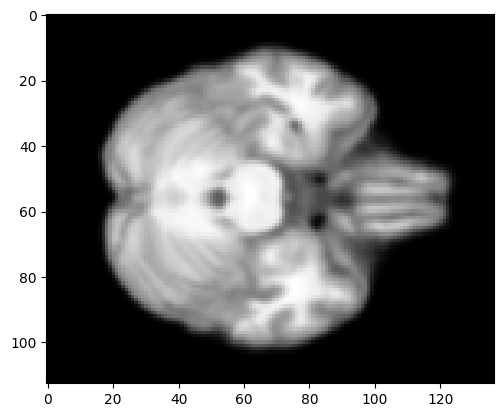

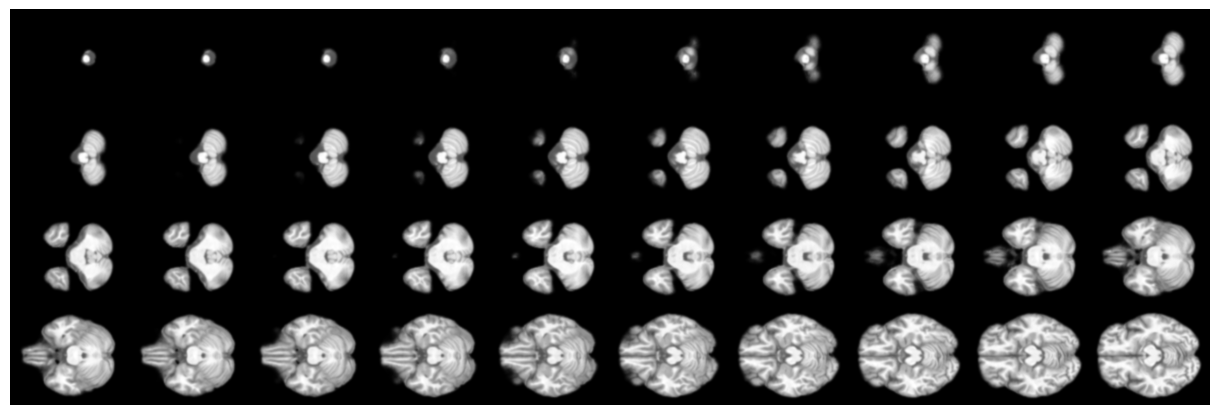

In [3]:
# -*- coding: utf-8 -*-

import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


# Loading data

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)

    return volume


"""Let's read the paths of the MRI scans from the class directories."""


CN_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/2023 의학영상처리/task_2/CN", x)
    for x in os.listdir("/content/drive/MyDrive/2023 의학영상처리/task_2/CN")
]

MCI_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/2023 의학영상처리/task_2/MCI", x)
    for x in os.listdir("/content/drive/MyDrive/2023 의학영상처리/task_2/MCI")
]

AD_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/2023 의학영상처리/task_2/AD", x)
    for x in os.listdir("/content/drive/MyDrive/2023 의학영상처리/task_2/AD")
]


print("MRI scans of CN : " + str(len(CN_scan_paths)))
print("MRI scans of MCI : " + str(len(MCI_scan_paths)))
print("MRI scans of AD : " + str(len(AD_scan_paths)))

"""## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.
"""


CN_scans = np.array([process_scan(path) for path in CN_scan_paths])
MCI_scans = np.array([process_scan(path) for path in MCI_scan_paths])
AD_scans = np.array([process_scan(path) for path in AD_scan_paths])




CN_labels = np.array([[1, 0, 0] for _ in range(len(CN_scans))])
MCI_labels = np.array([[0, 1, 0] for _ in range(len(MCI_scans))])
AD_labels = np.array([[0, 0, 1] for _ in range(len(AD_scans))])




# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((CN_scans[:14], MCI_scans[:14], AD_scans[:14]), axis=0)
y_train = np.concatenate((CN_labels[:14], MCI_labels[:14], AD_labels[:14]), axis=0)
x_val = np.concatenate((CN_scans[14:18], MCI_scans[14:18], AD_scans[14:18]), axis=0)
y_val = np.concatenate((CN_labels[14:18], MCI_labels[14:18], AD_labels[14:18]), axis=0)
x_test = np.concatenate((CN_scans[18:20], MCI_scans[18:20], AD_scans[18:20]), axis=0)
y_test = np.concatenate((CN_labels[18:20], MCI_labels[18:20], AD_labels[18:20]), axis=0)
print(
    "Number of samples in train and validation and test are %d and %d and %d."
     % (x_train.shape[0], x_val.shape[0], x_test.shape[0])
)



import random

from scipy import ndimage


# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 2

train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

test_dataset = (
    test_loader.shuffle(len(x_test))
    .batch(batch_size)
    .prefetch(2)
)


import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

"""Since a MRI scan has many slices, let's visualize a montage of the slices."""

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 113, 137, image[:, :, :40])

In [4]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(42, 113, 137, 113)
(12, 113, 137, 113)
(6, 113, 137, 113)


# 모델 선언

In [5]:
# Define a 3D convolutional neural network
def get_model(width=113, height=137, depth=113):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=3, activation="softmax")(x)


    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=113, height=137, depth=113)
model.summary()


Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113, 137, 113,    0         
                             1)]                                 
                                                                 
 conv3d (Conv3D)             (None, 111, 135, 111, 6   1792      
                             4)                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 55, 67, 55, 64)    0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 55, 67, 55, 64)    256       
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 53, 65, 53, 64)    110656

# 훈련 및 검증

Epoch 1/12
21/21 - 16s - loss: 1.0042 - acc: 0.5476 - val_loss: 1.1974 - val_acc: 0.3333 - 16s/epoch - 770ms/step
Epoch 2/12


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 - 2s - loss: 0.8754 - acc: 0.5952 - val_loss: 1.8808 - val_acc: 0.3333 - 2s/epoch - 112ms/step
Epoch 3/12
21/21 - 3s - loss: 0.8504 - acc: 0.4762 - val_loss: 2.9106 - val_acc: 0.3333 - 3s/epoch - 122ms/step
Epoch 4/12
21/21 - 3s - loss: 0.9544 - acc: 0.4524 - val_loss: 4.0334 - val_acc: 0.3333 - 3s/epoch - 121ms/step
Epoch 5/12
21/21 - 2s - loss: 0.7241 - acc: 0.6190 - val_loss: 5.2996 - val_acc: 0.3333 - 2s/epoch - 111ms/step
Epoch 6/12
21/21 - 2s - loss: 1.0449 - acc: 0.5238 - val_loss: 5.1742 - val_acc: 0.3333 - 2s/epoch - 111ms/step
Epoch 7/12
21/21 - 2s - loss: 0.8377 - acc: 0.5952 - val_loss: 5.5665 - val_acc: 0.3333 - 2s/epoch - 111ms/step
Epoch 8/12
21/21 - 2s - loss: 0.8496 - acc: 0.6190 - val_loss: 6.7172 - val_acc: 0.3333 - 2s/epoch - 112ms/step
Epoch 9/12
21/21 - 3s - loss: 0.8292 - acc: 0.5238 - val_loss: 6.0155 - val_acc: 0.3333 - 3s/epoch - 120ms/step
Epoch 10/12
21/21 - 2s - loss: 0.8480 - acc: 0.5714 - val_loss: 6.9631 - val_acc: 0.3333 - 2s/epoch - 108ms/step
Ep

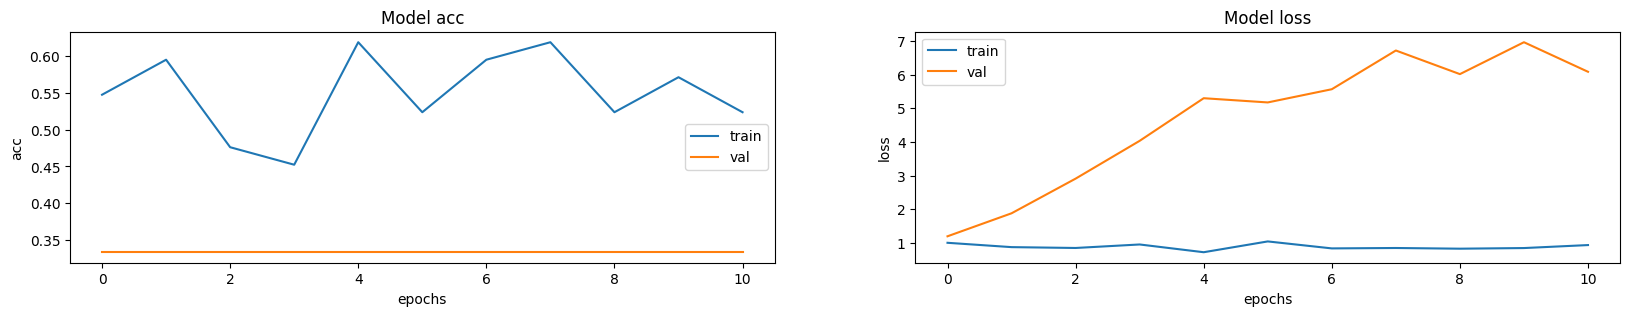

In [6]:
from keras import metrics

# Train model"""

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics= ['acc']
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=10)



# Train the model, doing validation at the end of each epoch
epochs = 12
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb])


fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# 모델 추론

1/1 [==============================] - 0s 23ms/step
Predicted: MCI, Actual: CN
Confidence Scores: {'CN': 31.21, 'MCI': 51.91, 'AD': 16.88}

1/1 [==============================] - 0s 22ms/step
Predicted: MCI, Actual: CN
Confidence Scores: {'CN': 31.21, 'MCI': 51.92, 'AD': 16.87}

1/1 [==============================] - 0s 22ms/step
Predicted: MCI, Actual: MCI
Confidence Scores: {'CN': 31.2, 'MCI': 51.94, 'AD': 16.86}

1/1 [==============================] - 0s 22ms/step
Predicted: MCI, Actual: MCI
Confidence Scores: {'CN': 31.21, 'MCI': 51.88, 'AD': 16.91}

1/1 [==============================] - 0s 22ms/step
Predicted: MCI, Actual: AD
Confidence Scores: {'CN': 31.23, 'MCI': 51.78, 'AD': 16.99}

1/1 [==============================] - 0s 21ms/step
Predicted: MCI, Actual: AD
Confidence Scores: {'CN': 31.22, 'MCI': 51.8, 'AD': 16.98}

1/1 [==============================] - 0s 25ms/step
Sample 1: Predicted: MCI, Actual: CN

1/1 [==============================] - 0s 23ms/step
Sample 2: Predicte

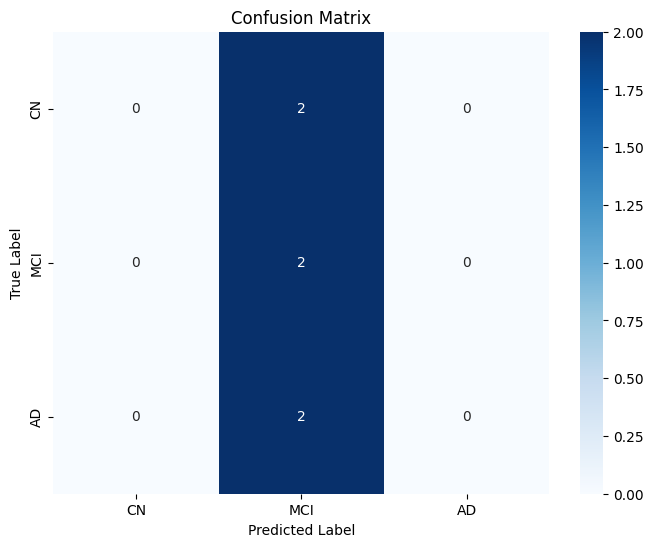

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load best weights.
model.load_weights("3d_image_classification.h5")

def answer(l):
    if np.array_equal(l, [1, 0, 0]):
        return "CN"
    elif np.array_equal(l, [0, 1, 0]):
        return "MCI"
    else:
        return "AD"

class_names = ['CN','MCI',"AD"]

for i in range(6):
    prediction = model.predict(np.expand_dims(x_test[i], axis=0))[0]

    predicted_label = class_names[np.argmax(prediction)]
    actual_label = answer(y_test[i])

    print("Predicted: {}, Actual: {}".format(predicted_label, actual_label))

    scores = [round(score * 100, 2) for score in prediction]
    print("Confidence Scores:", dict(zip(class_names, scores)))

    print()

class_names = ['CN', 'MCI', 'AD']

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

for i in range(6):
    # Make a prediction
    prediction = model.predict(np.expand_dims(x_test[i], axis=0))[0]

    # Map predicted and actual labels to class names
    predicted_label = class_names[np.argmax(prediction)]
    actual_label = answer(y_test[i])

    # Append true and predicted labels to the lists
    true_labels.append(actual_label)
    predicted_labels.append(predicted_label)

    # Print the results (if needed)
    print("Sample {}: Predicted: {}, Actual: {}".format(i + 1, predicted_label, actual_label))
    print()

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Visualize confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#성능평가

6/6 [==============================] - 0s 17ms/step
Accuracy: 0.3333
Precision: 0.1111
Recall: 0.3333
F1 Score: 0.1667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


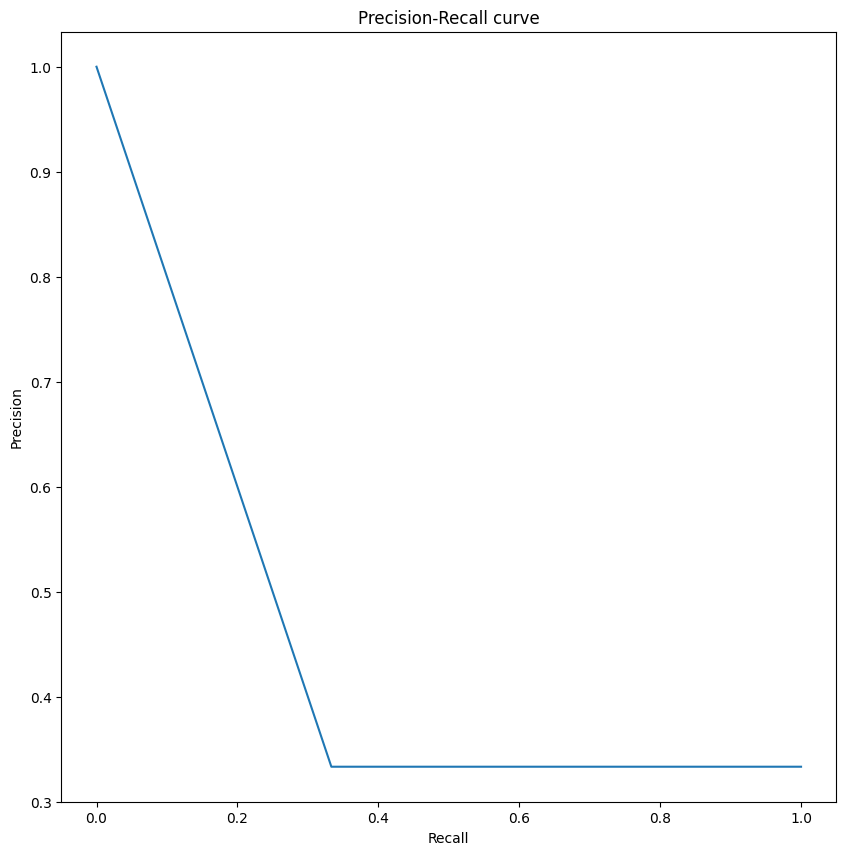

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# Assuming model.predict, x_test, y_test are defined elsewhere in your code
matrix = model.predict(x_test, batch_size=1)

binary_matrix = np.zeros_like(matrix)
binary_matrix[np.arange(len(matrix)), matrix.argmax(axis=1)] = 1
y_pred = binary_matrix
y_true = y_test

# Compute the metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

plt.figure()
plt.title("Precision-Recall curve")
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# Gradcam

1/1 [==============================] - 0s 23ms/step
Predicted: [0.31208572 0.51912075 0.16879357]


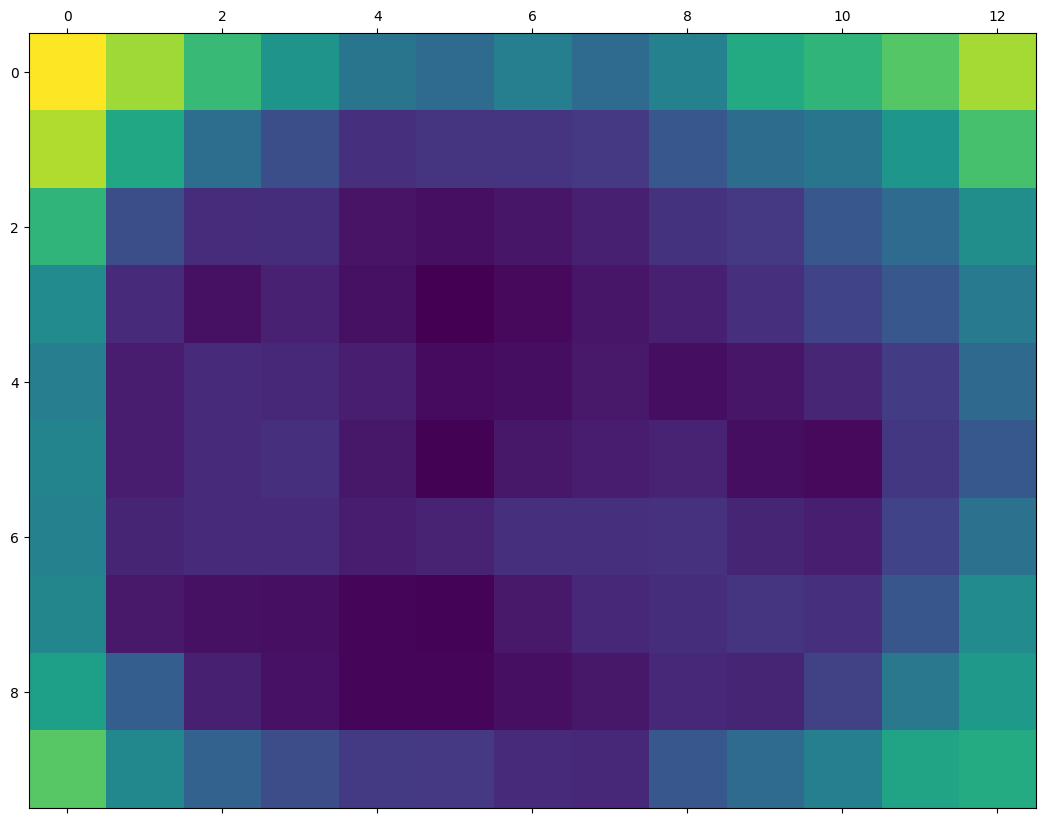

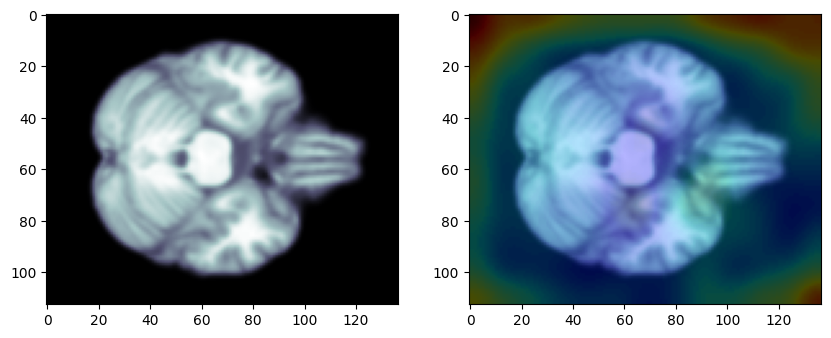

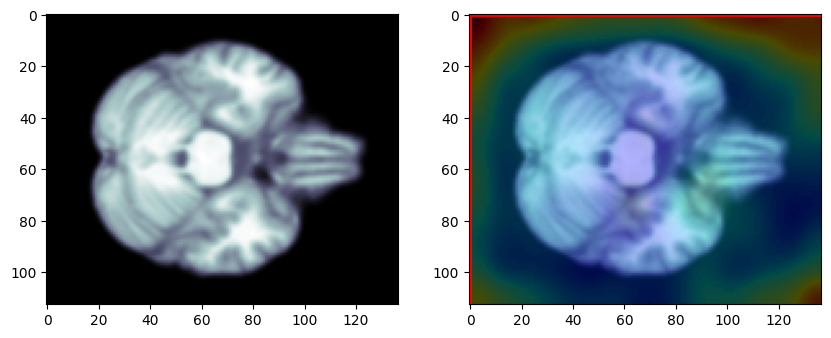

interactive(children=(IntSlider(value=68, description='x', max=136), IntSlider(value=56, description='y', max=…

interactive(children=(IntSlider(value=68, description='x', max=136), IntSlider(value=56, description='y', max=…

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import cv2
from matplotlib.patches import Rectangle
from ipywidgets import interact, IntSlider
from matplotlib.path import Path
from matplotlib.patches import PathPatch

#Grad-cam visualization

input_volume = x_test[0]
volume_size = input_volume.shape
last_conv_layer_name = 'conv3d_3'


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate class activation heatmap"""
    # Build a new model with a single input
    new_model = tf.keras.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = new_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # The rest of the function remains the same...

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel (equivalent to global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

    # We multiply each channel in the feature map array
    # by 'how important this channel is' with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # Notice that we clip the heatmap values, which is equivalent to applying ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



#heat-map generation

# Remove last layer's activation
model.layers[-1].activation = None

# Print what the top predicted class is
img_array = np.expand_dims(input_volume, axis=0)

preds = model.predict(img_array)
print('Predicted:', preds[0])

# 모델이 하나의 입력을 가지고 있다고 가정합니다
heatmap = make_gradcam_heatmap(np.expand_dims(input_volume, axis=0), model, last_conv_layer_name)

# 히트맵의 슬라이스를 시각화합니다 (필요한 경우 인덱스를 조절하세요)
plt.matshow(np.squeeze(heatmap[:, :,6]))
plt.show()


#expanding heatmap dimensions
def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to shape"""
    # Rescale heatmap to a range 0-255
    upscaled_heatmap = np.uint8(255 * heatmap)

    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],
            shape[1] / upscaled_heatmap.shape[1],
            shape[2] / upscaled_heatmap.shape[2],
        ),
    )

    return upscaled_heatmap


resized_heatmap = get_resized_heatmap(heatmap, input_volume.shape)

#visualizations
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()



#bounding boxes

def get_bounding_boxes(heatmap, threshold=0.15, otsu=False):
    """Get bounding boxes from heatmap"""
    p_heatmap = np.copy(heatmap)

    if otsu:
        # Otsu's thresholding method to find the bounding boxes
        threshold, p_heatmap = cv2.threshold(
            heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
    else:
        # Using a fixed threshold
        p_heatmap[p_heatmap < threshold * 255] = 0
        p_heatmap[p_heatmap >= threshold * 255] = 1

    # find the contours in the thresholded heatmap
    contours = cv2.findContours(p_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # get the bounding boxes from the contours
    bboxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        bboxes.append([x, y, x + w, y + h])

    return bboxes


def get_bbox_patches(bboxes, color='r', linewidth=2):
    """Get patches for bounding boxes"""
    patches = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        patches.append(
            Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                edgecolor=color,
                facecolor='none',
                linewidth=linewidth,
            )
        )
    return patches


# show the bounding boxes on the original image
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())

bboxes = get_bounding_boxes(np.squeeze(resized_heatmap[:, :, 30]))
patches = get_bbox_patches(bboxes)

for patch in patches:
    ax[1].add_patch(patch)

plt.show()


#interactive slice viewers
def _draw_line(ax, coords, clr='g'):
    line = Path(coords, [Path.MOVETO, Path.LINETO])
    pp = PathPatch(line, linewidth=3, edgecolor=clr, facecolor='none')
    ax.add_patch(pp)


def _set_axes_labels(ax, axes_x, axes_y):
    ax.set_xlabel(axes_x)
    ax.set_ylabel(axes_y)
    ax.set_aspect('equal', 'box')


def _draw_bboxes(ax, heatmap):
    bboxes = get_bounding_boxes(heatmap, otsu=True)
    patches = get_bbox_patches(bboxes)
    for patch in patches:
        ax.add_patch(patch)


_rec_prop = dict(linewidth=5, facecolor='none')


def show_volume(vol, z, y, x, heatmap=None, alpha=0.3, fig_size=(6, 6)):
    """Show a slice of a volume with optional heatmap"""
    fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=fig_size)
    v_z, v_y, v_x = vol.shape

    img0 = axarr[0, 0].imshow(vol[z, :, :], cmap='bone')
    if heatmap is not None:
        axarr[0, 0].imshow(
            heatmap[z, :, :], cmap='jet', alpha=alpha, extent=img0.get_extent()
        )
        _draw_bboxes(axarr[0, 0], heatmap[z, :, :])

    axarr[0, 0].add_patch(Rectangle((-1, -1), v_x, v_y, edgecolor='r', **_rec_prop))
    _draw_line(axarr[0, 0], [(x, 0), (x, v_y)], 'g')
    _draw_line(axarr[0, 0], [(0, y), (v_x, y)], 'b')
    _set_axes_labels(axarr[0, 0], 'X', 'Y')

    img1 = axarr[0, 1].imshow(vol[:, :, x].T, cmap='bone')
    if heatmap is not None:
        axarr[0, 1].imshow(
            heatmap[:, :, x].T, cmap='jet', alpha=alpha, extent=img1.get_extent()
        )
        _draw_bboxes(axarr[0, 1], heatmap[:, :, x].T)

    axarr[0, 1].add_patch(Rectangle((-1, -1), v_z, v_y, edgecolor='g', **_rec_prop))
    _draw_line(axarr[0, 1], [(z, 0), (z, v_y)], 'r')
    _draw_line(axarr[0, 1], [(0, y), (v_x, y)], "b")
    _set_axes_labels(axarr[0, 1], 'Z', 'Y')

    img2 = axarr[1, 0].imshow(vol[:, y, :], cmap='bone')
    if heatmap is not None:
        axarr[1, 0].imshow(
            heatmap[:, y, :], cmap='jet', alpha=alpha, extent=img2.get_extent()
        )
        _draw_bboxes(axarr[1, 0], heatmap[:, y, :])

    axarr[1, 0].add_patch(Rectangle((-1, -1), v_x, v_z, edgecolor='b', **_rec_prop))
    _draw_line(axarr[1, 0], [(0, z), (v_x, z)], 'r')
    _draw_line(axarr[1, 0], [(x, 0), (x, v_y)], 'g')
    _set_axes_labels(axarr[1, 0], 'X', 'Z')
    axarr[1, 1].set_axis_off()
    fig.tight_layout()


def interactive_show(volume, heatmap=None):
    """Show a volume interactively"""
    # transpose volume from (x, y, z) to (z, y, x)
    volume = np.transpose(volume, (2, 0, 1))
    if heatmap is not None:
        heatmap = np.transpose(heatmap, (2, 0, 1))
    vol_shape = volume.shape

    interact(
        lambda x, y, z: plt.show(show_volume(volume, z, y, x, heatmap)),
        z=IntSlider(min=0, max=vol_shape[0] - 1, step=1, value=int(vol_shape[0] / 2)),
        y=IntSlider(min=0, max=vol_shape[1] - 1, step=1, value=int(vol_shape[1] / 2)),
        x=IntSlider(min=0, max=vol_shape[2] - 1, step=1, value=int(vol_shape[2] / 2)),
    )


interactive_show(input_volume)

interactive_show(input_volume, resized_heatmap)

# Animation으로 확인


In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

plt.rc('figure', figsize=(10, 10))

def create_animation(array, case, heatmap=None, alpha=0.3):
    """Create an animation of a volume"""
    array = np.transpose(array, (2, 0, 1))
    if heatmap is not None:
        heatmap = np.transpose(heatmap, (2, 0, 1))
    fig = plt.figure(figsize=(4, 4))
    images = []
    for idx, image in enumerate(array):
        # plot image without notifying animation
        image_plot = plt.imshow(image, animated=True, cmap='bone')
        aux = [image_plot]
        if heatmap is not None:
            image_plot2 = plt.imshow(
                heatmap[idx], animated=True, cmap='jet', alpha=alpha, extent=image_plot.get_extent())
            aux.append(image_plot2)

            # add bounding boxes to the heatmap image as animated patches
            bboxes = get_bounding_boxes(heatmap[idx])
            patches = get_bbox_patches(bboxes)
            aux.extend(image_plot2.axes.add_patch(patch) for patch in patches)
        images.append(aux)

    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.title(f'Patient ID: {case}', fontsize=16)
    ani = animation.ArtistAnimation(
        fig, images, interval=5000//len(array), blit=False, repeat_delay=1000)
    plt.close()
    return ani


In [10]:
from IPython.display import HTML

ani = create_animation(input_volume, 'Test', heatmap=resized_heatmap)
HTML(ani.to_jshtml())


Output hidden; open in https://colab.research.google.com to view.